# Benoit's Problem with various RTO Algorithms

In [33]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt

# 0. Benoit's Problem

In [34]:

# Actual Plant System
def Benoit_System_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2 + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2. + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def con1_system_tight(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def Benoit_System_noiseless_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1]   # + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_noiseless_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2  # + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2.  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

def con1_system_tight_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1]  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

## Diagram for Benoit's Problem

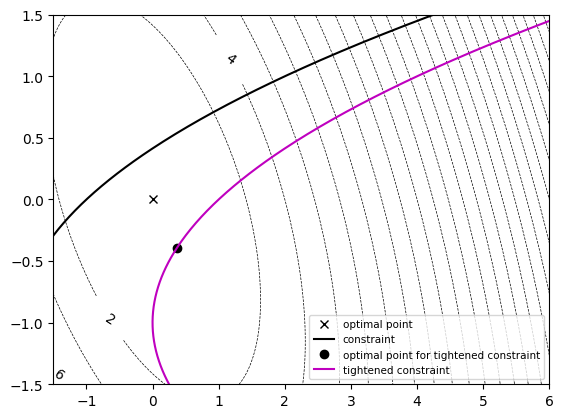

In [35]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-6.5, 6.5, delta)
        y = np.arange(-6.5, 6.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,50,26)

        CS1 = plt.contour(u[0],u[1],Benoit_System_noiseless_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1.5, 6.0, -1.5, 1.5))

        if is_constraint == True:
                # Plot for optimal value for optimization with constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_noiseless(u)}) 
                result = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})
                
                ustar = result.x
                fstar = result.fun
                plt.plot(ustar[0],ustar[1],'kx')
                
                # Plot for constraint
                uc0 = 1. + x ** 2 + 2. * x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:

                # Plot for optimal value for optimization with tightened constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_tight_noiseless(u)}) 
                result_tight = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})

                ustar = result_tight.x
                fstar = result_tight.fun
                plt.plot(ustar[0],ustar[1],'ko')

                # Plot for tightened constraint

                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()

# 1. Modifier Adaptation

## A. Benoit Model

In [36]:
# Plant Model 
def Benoit_Model(u,u0,theta,modifier):

    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2 + modifier[0]*(u[0]) + modifier[1]*(u[1])
    return f

def con1_model(u,u0,theta,modifier):

    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 + modifier[2] + modifier[3]*(u[0]-u0[0]) + modifier[4]*(u[1]-u0[1])
    return -g1


## B. Optimization on Cost Function

In [37]:
def cost_optimize(u0,theta,modifier):

    con = ({'type': 'ineq',
            'fun': lambda u: con1_model(u,u0,theta,modifier)})
    
    result = minimize((Benoit_Model),
                    u0,
                    constraints= con,
                    method='SLSQP',
                    options= {'ftol': 1e-9},
                    args= (u0,theta,modifier))
    
    return result.x,result.fun

In [38]:
# # Test
# u0 = [1,1] # Initial guess for optimization algorithm
# modifier = [1,1,1,1,1]
# theta = [0.5,0.5,0.5,0.5]

# u,fun = cost_optimize(u0,theta,modifier)

# print(f"optimal input: {u}, optimal output: {fun}")

## C. Modifier Adaptation

In [39]:
# gradient modifier
def gradient_estimation(u,fun):
    # step
    du = np.sqrt(1e-3) # np.finfo
    u = np.array(u)
    # Predicted gradient from real plant
    gradient_u0 = (fun(u+[du,0]) - fun(u))/du
    gradient_u1 = (fun(u+[0,du]) - fun(u))/du
    gradient = [gradient_u0,gradient_u1]
    
    return gradient

# Modifier Update
def modifier_update(u,u0,theta,modifier,plant_fun,plant_con1):
    
    # Calculate relavent bias and gradients:
    gradient_cost_p = gradient_estimation(u,plant_fun)
    ## Gradient of plant constraint function
    gradient_con1_p = gradient_estimation(u,plant_con1)
    ## Gradient of model cost function
    gradient_cost_m = approx_fprime(u,Benoit_Model,np.sqrt(1e-3),u0,theta,modifier)
    ## Gradient of model constraint function
    gradient_con1_m = approx_fprime(u,con1_model,np.sqrt(1e-3),u0,theta,modifier)
    ## Gradient of plant cost function

    # Calculate difference between plant and model
    lamda_0 = gradient_cost_p - gradient_cost_m
    epsil = -(plant_con1(u) - con1_model(u,u0,theta,modifier))
    lamda_1 = -1*(gradient_con1_p - gradient_con1_m)
    
    return [lamda_0[0],lamda_0[1],epsil,lamda_1[0],lamda_1[1]]

# Modifier Adaptation
def adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K):
    new_modifier = modifier_update(u,u0,theta,modifier,plant_fun,plant_con1)
    I = np.identity(len(modifier))

    for i in range(len(modifier)):
        modifier[i] = (I - K)[i,i]*modifier[i] + K[i,i]*new_modifier[i]

    return modifier

In [40]:
# # Test
# ## Variable
# u = [-0.20316229, -0.80316225]
# u0 = [-1,-1]
# modifier = [1,1,1,1,1]
# theta = [0.5,0.5,0.5,0.5]
# plant_fun = Benoit_System_noiseless_1
# plant_con1 = con1_system_tight_noiseless
# K = np.identity(len(modifier))*0.2

# # Modifier Adaptation
# modifier = adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K)
# print(f"New Modifier: {modifier}")

## D. Overall Algorithm

### I.Plant System 1: 
- "Benoit_System_noiseless_1"
- "con1_system_noiseless" constraint

In [41]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = [0.5,0.5,0.5,0.5]
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_noiseless
K = np.identity(len(modifierk))*0.2

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(10):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,uk,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

### II Result

#### i. Trace of optimal inputs made by Modifier Adaptation Algorithm

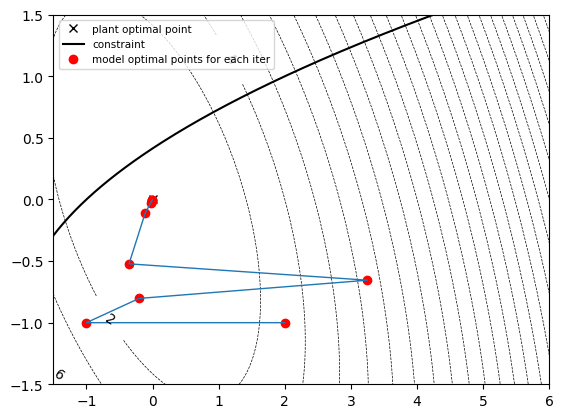

In [42]:
plant_drawing(is_constraint=True,is_tight_constraint=False)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter'],
                fontsize = 7.5)
plt.show()

#### ii. Cost Function through 5 iterations

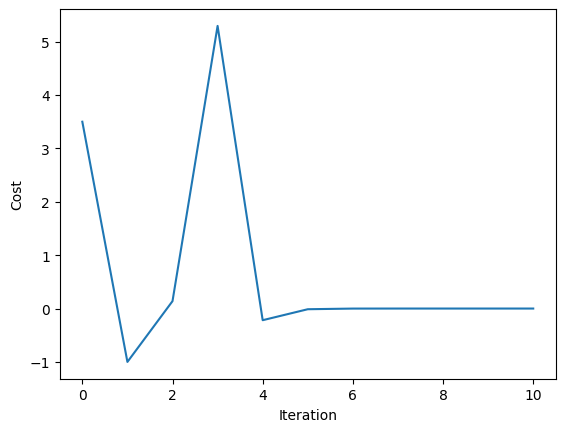

In [43]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Modifiers of model through 5 iterations

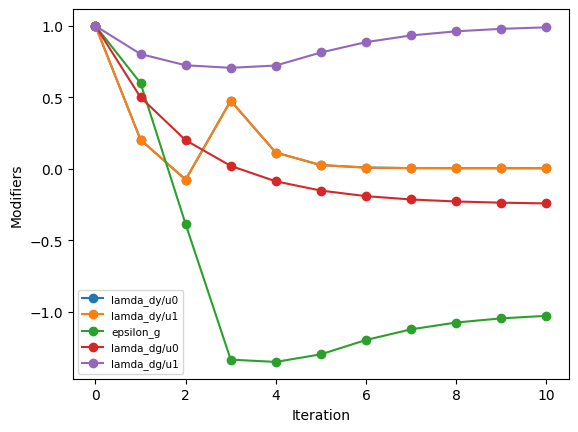

In [44]:
plt.plot(data['index'],
         data['modifiers'][0],
         data['index'],
         data['modifiers'][1],
         data['index'],
         data['modifiers'][2],
         data['index'],
         data['modifiers'][3],
         data['index'],
         data['modifiers'][4],
         marker='o')
plt.legend(["lamda_dy/u0",
            "lamda_dy/u1",
            "epsilon_g",
            "lamda_dg/u0",
            "lamda_dg/u1"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Modifiers")
plt.show()

### III.Plant System_2: 
- "Benoit_System_noiseless_1", 
- "con1_system_tight_noiseless" constraint

In [45]:
# Initial Guess (k=0)
uk = [2,-1]
modifierk = [1,1,1,1,1]
theta = [0.5,0.5,0.5,0.5]
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(len(modifierk))*0.2

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['modifiers'] = []
for i in modifierk:
    data['modifiers'].append([i])
data['cost'] = [Benoit_Model(u=uk,u0=uk,theta=theta,modifier=modifierk)]

# Algorithm
for i in range(10):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,uk,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(modifierk)):
        data['modifiers'][i].append(modifierk[i])
    data['cost'].append(fun) 

### IV Result

#### i. Trace of optimal inputs made by Modifier Adaptation Algorithm

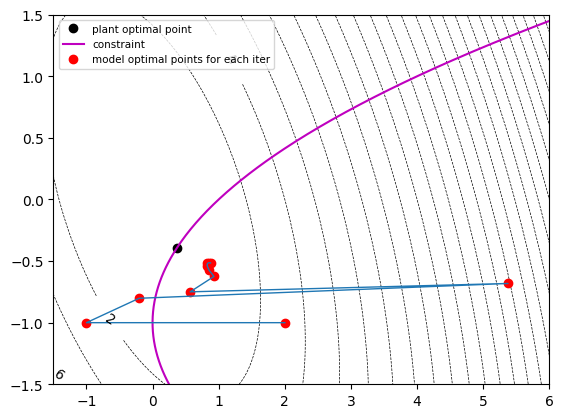

In [46]:
plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter'],
                fontsize = 7.5)
plt.show()

#### ii. Cost Function through 5 iterations

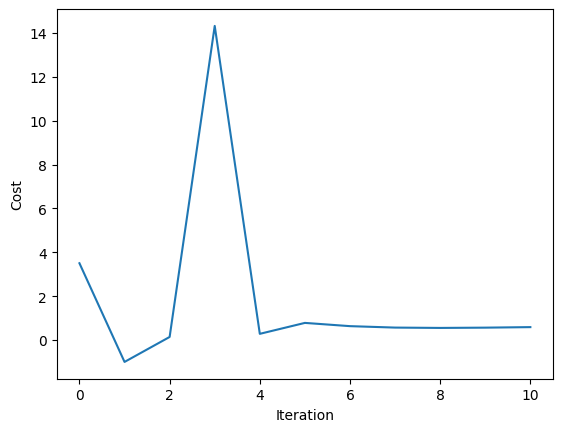

In [47]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Modifiers of model through 5 iterations

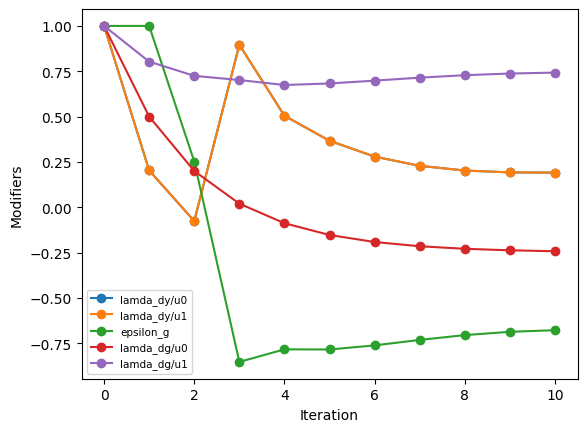

In [48]:
plt.plot(data['index'],
         data['modifiers'][0],
         data['index'],
         data['modifiers'][1],
         data['index'],
         data['modifiers'][2],
         data['index'],
         data['modifiers'][3],
         data['index'],
         data['modifiers'][4],
         marker='o')
plt.legend(["lamda_dy/u0",
            "lamda_dy/u1",
            "epsilon_g",
            "lamda_dg/u0",
            "lamda_dg/u1"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Modifiers")
plt.show()